# **EEG PATTERN RECOGNITION**


#### **Objective**
> **Classify mental attention states (`focused`, `unfocused`, `drowsy`) based on EEG signals using machine learning techniques.**



---



## **Introduction to Data**

##Introduction
Advances in automation and robotics have created environments where human roles are often reduced to passive observation. While this enhances productivity and lifestyle, it also presents risks, particularly the inability to maintain attention during passive control tasks. Brain-computer interfaces (BCIs) offer a solution by monitoring mental states, enabling the detection of issues like drowsiness or lack of focus.

This study investigates mental attention states—focused, unfocused, and drowsy—using non-invasive electroencephalography (EEG) combined with machine learning methods. The focus is on tasks where individuals passively monitor processes without actively engaging, such as supervising automated systems. Unlike previous works that often utilized auxiliary data like respiration or task engagement indices, this research aims to detect mental states solely based on EEG data. By using a modified EEG setup, this study achieves a high accuracy of up to 96.7% in distinguishing mental states.

##Experimental Procedure and Data Description
A total of 25 hours of EEG recordings were collected from 5 participants during a passive observation task using a train simulation program. Each participant controlled a train for 35–55 minutes on a featureless route, with tasks organized into three mental states:
*   Focused State: Participants monitored the simulation attentively, maintaining concentration. (first 10 minutes)
*   List item: Unfocused State: Participants remained awake but detached, no longer concentrating on the task. (next 10 minutes)
*   Drowsy State: Participants were allowed to relax, close their eyes, and drift into a drowsy state. (remain)

The EEG data was recorded using a modified Emotiv Epoc EEG headset with electrodes placed over the frontal and parietal lobes, allowing high-resolution signal capture. The data was processed to extract time-frequency features, focusing on frequencies between 1–18 Hz, which are most relevant to attention and drowsiness detection.

Each participant completed seven trials, with the first two used for acclimatization and the remaining five for data collection. This design ensured high-quality data for both training and validation of the machine learning models.



---



## **Library**

In [1]:
# !pip install seaborn
# !pip install skorch
# !pip install tqdm
# !pip install torch
# !pip install imblearn

In [2]:
import time
import random

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Signal processing
from scipy.io import loadmat
from scipy.signal import butter, lfilter, stft, get_window

# Machine Learning models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Preprocessing and feature extraction
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

# Metrics
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    confusion_matrix, 
    roc_curve, 
    auc, 
    classification_report
)

# Deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Utilities
import pickle
from copy import deepcopy


## **Loading Data**

In [ ]:
# clone repo from github to local environment
!git clone https://github.com/Hoang2603/Mental-Attention-States-Classification-EEG/tree/main/data

fatal: destination path 'PR-Midterm' already exists and is not an empty directory.


In [ ]:
FS = 128 #Frequency
N_SUBJECTS = 5 #Number of test subject
MKPT1 = int(FS*10*60)
MKPT2 = int(FS*20*60)

# Adjust the frequency band thresholds of EEG data used
LOW_CUT = 0.2 * 128
HIGH_CUT = 43 *128

# Directory to dataset
inp_dir = 'C:/Users/LENOVO/Hoang2603/Mental-Attention-States-Classification-EEG/tree/main/data' 

In [5]:
subject_map = {} # Information of trial days for every test subjects
for s in range(1, N_SUBJECTS+1):
    a =  int(7*(s-1)) + 1
    if s!=5:
        b = a + 7
    else:
        b = a + 6
    subject_map[s] = [i for i in range(a, b)]

channels = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4'] #Channel's types


In [6]:
# Save .mat files into pickle files, categorized by subject
"""
The first two trials are for familiarization with the experimental environment and are therefore excluded. 
Only subsequent trials are considered.

For each subject's file, append all the trials into a dictionary named `data`. 
The assumption is that these trials are independent, and combining all the trials into a single dataset 
enables more comprehensive analysis.
"""

# Dictionary to store all subjects' data
all_data = {'channels': channels,
        'fs': FS,
        'focussed': [],
        'unfocussed': [],
        'drowsed': []
}

# Create an array storing data length of all subject for each state (the order is subject_num first, state second)
# Using this for latter spliting data into 4 subject for training and 1 subject for testing
subject_state_len = np.zeros(N_SUBJECTS * 3, dtype=int)

for s in range(1, N_SUBJECTS + 1):
    subject_data = {
        'focussed': [],
        'unfocussed': [],
        'drowsed': []
    }

    # Iterate over trials for the subject
    for i, t in enumerate(subject_map[s]):
        if i < 2:  # Skip the first two trials
            continue

        # Load trial data
        trial_data = loadmat(inp_dir + f'eeg_record{t}.mat')
        eeg = trial_data['o']['data'][0][0][:, 3:17]

        # Combine trial data into respective states
        subject_data['focussed'].append(eeg[:MKPT1])
        subject_data['unfocussed'].append(eeg[MKPT1:MKPT2])
        subject_data['drowsed'].append(eeg[MKPT2:])

        # Calculate length of data
        subject_state_len[s - 1] += eeg[:MKPT1].shape[0]
        subject_state_len[s - 1 + N_SUBJECTS] += eeg[MKPT1:MKPT2].shape[0]
        subject_state_len[s - 1 + 2 * N_SUBJECTS] += eeg[MKPT2:].shape[0]

    # Change trial data into numpy array using np.concatenate
    subject_data['focussed'] = np.concatenate(subject_data['focussed'], axis=0)
    subject_data['unfocussed'] = np.concatenate(subject_data['unfocussed'], axis=0)
    subject_data['drowsed'] = np.concatenate(subject_data['drowsed'], axis=0)

    # Combine each subject trial data to all data
    if (s == 1):
        all_data['focussed'] = subject_data['focussed']
        all_data['unfocussed'] = subject_data['unfocussed']
        all_data['drowsed'] = subject_data['drowsed']
    else:
        all_data['focussed'] = np.concatenate((all_data['focussed'], subject_data['focussed']), axis=0)
        all_data['unfocussed'] = np.concatenate((all_data['unfocussed'], subject_data['unfocussed']), axis=0)
        all_data['drowsed'] = np.concatenate((all_data['drowsed'], subject_data['drowsed']), axis=0)

# Save the combined data for all subjects
with open('all_subjects.pkl', 'wb') as f:
    pickle.dump(all_data, f, pickle.HIGHEST_PROTOCOL)

In [7]:
print(all_data['focussed'].shape)
print(all_data['unfocussed'].shape)
print(all_data['drowsed'].shape)

(1843200, 14)
(1843200, 14)
(5316584, 14)


##### Now, structure of all_data:

The all_data dictionary will have the following format:

- **Key**: Represents the three states:
    - "focused"
    - "unfocused"
    - "drowsed"

- **Value**: A 2D array with shape (x, 14), where:
    - `x` is the number of data points for each state.
    - `14` represents the number of features (e.g., EEG channels).

Example:
all_data = {
    
    "focused": np.array([...]),   # Shape: (1843200, 14)

    "unfocused": np.array([...]), # Shape: (1843200, 14)
    
    "drowsed": np.array([...])    # Shape: (5316584, 14)
}



## **Exploratory Data Analysis - EDA**

In [8]:
all_data

{'channels': ['AF3',
  'F7',
  'F3',
  'FC5',
  'T7',
  'P7',
  'O1',
  'O2',
  'P8',
  'T8',
  'FC6',
  'F4',
  'F8',
  'AF4'],
 'fs': 128,
 'focussed': array([[4440.51282051, 3804.1025641 , 5210.76923077, ..., 4282.56410256,
         4333.84615385, 4024.1025641 ],
        [4440.51282051, 3796.41025641, 5205.64102564, ..., 4282.56410256,
         4335.38461538, 4017.94871795],
        [4440.51282051, 3798.97435897, 5207.17948718, ..., 4282.56410256,
         4334.87179487, 4018.97435897],
        ...,
        [4442.56410256, 4003.07692308, 4892.82051282, ..., 4287.69230769,
         4330.76923077, 4148.20512821],
        [4440.51282051, 4004.1025641 , 4890.25641026, ..., 4286.15384615,
         4332.30769231, 4148.20512821],
        [4441.02564103, 4010.25641026, 4893.33333333, ..., 4285.64102564,
         4333.33333333, 4149.23076923]]),
 'unfocussed': array([[4440.        , 3714.87179487, 5206.66666667, ..., 4283.58974359,
         4335.8974359 , 4123.58974359],
        [4441.538461

In [9]:
subject_files = 'all_subjects.pkl'

### Show shape, ammount of channels and null value

In [10]:
# display length, num of channels and null value
for s in range(1, N_SUBJECTS + 1):
    print(f"Subject {s}:")
    count = 0
    for i, t in enumerate(subject_map[s]):

        trial_data = loadmat(inp_dir + f'eeg_record{t}.mat')
        eeg = trial_data['o']['data'][0][0][:, 3:17]
        print(f"eeg_record{t}.mat shape: {eeg.shape}")
        null_count = np.isnan(eeg).sum()
        if null_count > 0:
          count += 1
          print(f".     => Null count in eeg_record{t}.mat : {null_count}")
    if count == 0:
        print("DONT HAVE NULL on all trial days of this Subject!\n")

Subject 1:
eeg_record1.mat shape: (308868, 14)
eeg_record2.mat shape: (366020, 14)
eeg_record3.mat shape: (357224, 14)
eeg_record4.mat shape: (380344, 14)
eeg_record5.mat shape: (351204, 14)
eeg_record6.mat shape: (288752, 14)
eeg_record7.mat shape: (398816, 14)
DONT HAVE NULL on all trial days of this Subject!

Subject 2:
eeg_record8.mat shape: (365888, 14)
eeg_record9.mat shape: (388788, 14)
eeg_record10.mat shape: (381340, 14)
eeg_record11.mat shape: (391624, 14)
eeg_record12.mat shape: (356728, 14)
eeg_record13.mat shape: (373304, 14)
eeg_record14.mat shape: (345164, 14)
DONT HAVE NULL on all trial days of this Subject!

Subject 3:
eeg_record15.mat shape: (359164, 14)
eeg_record16.mat shape: (234372, 14)
eeg_record17.mat shape: (443972, 14)
eeg_record18.mat shape: (361840, 14)
eeg_record19.mat shape: (333236, 14)
eeg_record20.mat shape: (396812, 14)
eeg_record21.mat shape: (336280, 14)
DONT HAVE NULL on all trial days of this Subject!

Subject 4:
eeg_record22.mat shape: (324764, 14

### **Frequency of the data**

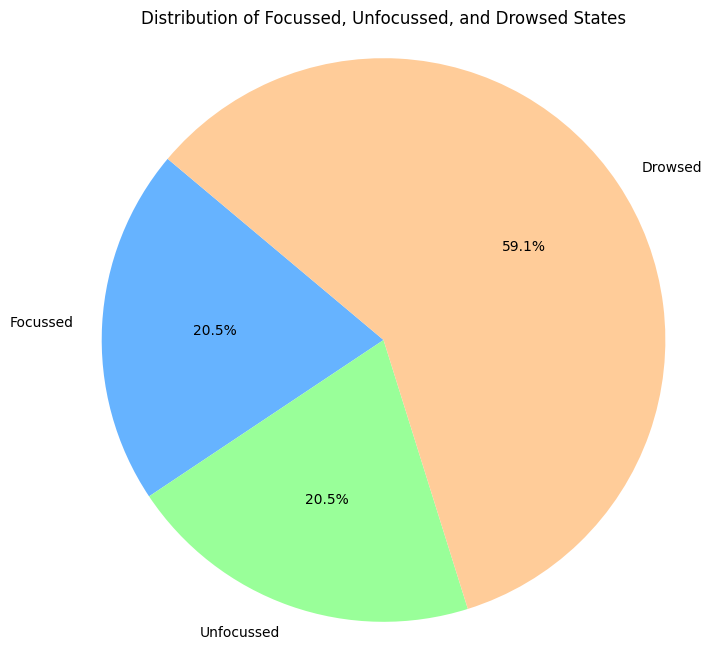

In [11]:
#Function to plot distribution of state labels
def plot_pie_chart_data_distribution(file_name):
    with open(file_name, 'rb') as f:
        data = pickle.load(f)

    # Calculate distribution sizes
    sizes = [len(data['focussed']), len(data['unfocussed']), len(data['drowsed'])]
    labels = ['Focussed', 'Unfocussed', 'Drowsed']
    colors = ['#66b3ff', '#99ff99', '#ffcc99']

    # Plot pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
    plt.title('Distribution of Focussed, Unfocussed, and Drowsed States')
    plt.axis('equal')
    plt.show()

# Visualize distribution
plot_pie_chart_data_distribution(subject_files)

#### Data Imbalance Observation

> As we can see, the dataset is imbalanced with significant differences in the distribution percentages across states. 
This is likely due to the nature of the problem and the sampling method. The distribution is as follows:

- **Focused**: 20.5%
- **Unfocused**: 20.5%
- **Drowsed**: 59.0%



In [12]:
# #Function to plot the signal distribution by channels over time
# def plot_channel_signals(subject_file, fs, channels, figsize=(15, 25)):
#     num_channels = len(channels)

#     fig, axes = plt.subplots(num_channels, 1, figsize=figsize, sharex=True)

#     with open(subject_file, 'rb') as f:
#         data = pickle.load(f)

#     combined_data = {
#         'focussed': data['focussed'],
#         'unfocussed': data['unfocussed'],
#         'drowsed': data['drowsed']
#     }

#     combined_time = np.array([])

#     for channel_idx, ax in enumerate(axes):
#         channel_combined_data = []
#         time_offset = 0

#         for state_name in ['focussed', 'unfocussed', 'drowsed']:
#             channel_data = combined_data[state_name][:, channel_idx]
#             time = np.arange(len(channel_data)) / fs + time_offset
#             channel_combined_data.append((time, channel_data))
#             time_offset = time[-1]

#         for time, channel_data in channel_combined_data:
#             ax.plot(time, channel_data)

#         ax.set_title(f'Channel {channels[channel_idx]}', fontsize=14)
#         ax.set_ylim(3500, 6000)
#         ax.set_xlabel('Time (s)', fontsize=12)
#         ax.set_ylabel('Amplitude (μV)', fontsize=12)
#         ax.grid(True)

#     axes[-1].legend(['Focussed', 'Unfocussed', 'Drowsed'], loc='upper right', fontsize=10)
#     plt.tight_layout()
#     plt.show()

# plot_channel_signals('all_subjects.pkl', FS, channels)

#### Observation from the Two Graphs Above
"""
From the two graphs above, the following observations can be made:

1. **Presence of Artifacts**: There are numerous artifacts in the data.
2. **Low Variability in Certain Channels**: Some channels have nearly constant amplitudes. 
   These channels hold little statistical significance and could be considered for removal.
"""




---



## **Data Preprocessing**

In [23]:
# create a copy data to hold origin data
all_data_c = deepcopy(all_data)

In [24]:
# filter useless channels
useful_channels = ['F7', 'F3', 'P7', 'O1', 'O2', 'P8', 'AF4']
useful_channels_index = [channels.index(channel) for channel in useful_channels]

for state in ['focussed', 'unfocussed', 'drowsed']:
    all_data_c[state] = all_data_c[state][:, useful_channels_index]

In [25]:
"""
Filter signals to keep only the frequency range from 0.2 to 43 Hz. 
Within this range, the remaining artifacts are primarily eye or muscle noise.
"""
def fill_outliers(data, threshold_low, threshold_high):
    # Create a mask to identify outlier samples (greater than HIGH_CUT or less than LOW_CUT)
    mask = (data < threshold_low) | (data > threshold_high)

    # Iterate through all samples and replace invalid values with the previous sample's value in the same channel (column)
    for i in range(1, data.shape[0]):
        # Replace invalid values in each channel (column) with the channel's value from the previous sample
        data[i, mask[i]] = data[i-1, mask[i]]

    return data

all_data_c = {
    state: fill_outliers(data, LOW_CUT, HIGH_CUT)
    for state, data in all_data_c.items()
    if state in ['focussed', 'unfocussed', 'drowsed']  # Filter for states to process
}

In [27]:
# Print the number of outlier data points after filtering
print("Number of outlier data points after filtering:\n")

# Upper threshold
print("Upper Threshold:")
print(f"Focused: {all_data_c['focussed'][all_data_c['focussed'] > 128 * 43].shape}")
print(f"Unfocused: {all_data_c['unfocussed'][all_data_c['unfocussed'] > 128 * 43].shape}")
print(f"Drowsed: {all_data_c['drowsed'][all_data_c['drowsed'] > 128 * 43].shape}")

# Lower threshold
print("Lower Threshold:")
print(f"Focused: {all_data_c['focussed'][all_data_c['focussed'] < 128 * 0.2].shape}")
print(f"Unfocused: {all_data_c['unfocussed'][all_data_c['unfocussed'] < 128 * 0.2].shape}")
print(f"Drowsed: {all_data_c['drowsed'][all_data_c['drowsed'] < 128 * 0.2].shape}")


Number of outlier data points after filtering:

Upper Threshold:
Focused: (0,)
Unfocused: (0,)
Drowsed: (0,)
Lower Threshold:
Focused: (0,)
Unfocused: (0,)
Drowsed: (0,)


> We can see that 'fill_outliers' function works good

In [28]:
# Normalize data by each channel and state
for state in ['focussed', 'unfocussed', 'drowsed']:
    for i, channel in enumerate(useful_channels):
        scaler = StandardScaler()
        all_data_c[state][:, i] = scaler.fit_transform(all_data_c[state][:, i].reshape(-1, 1)).flatten()

In [29]:
shape_focussed = all_data_c['focussed'].shape
shape_unfocussed = all_data_c['unfocussed'].shape
shape_drowsed = all_data_c['drowsed'].shape

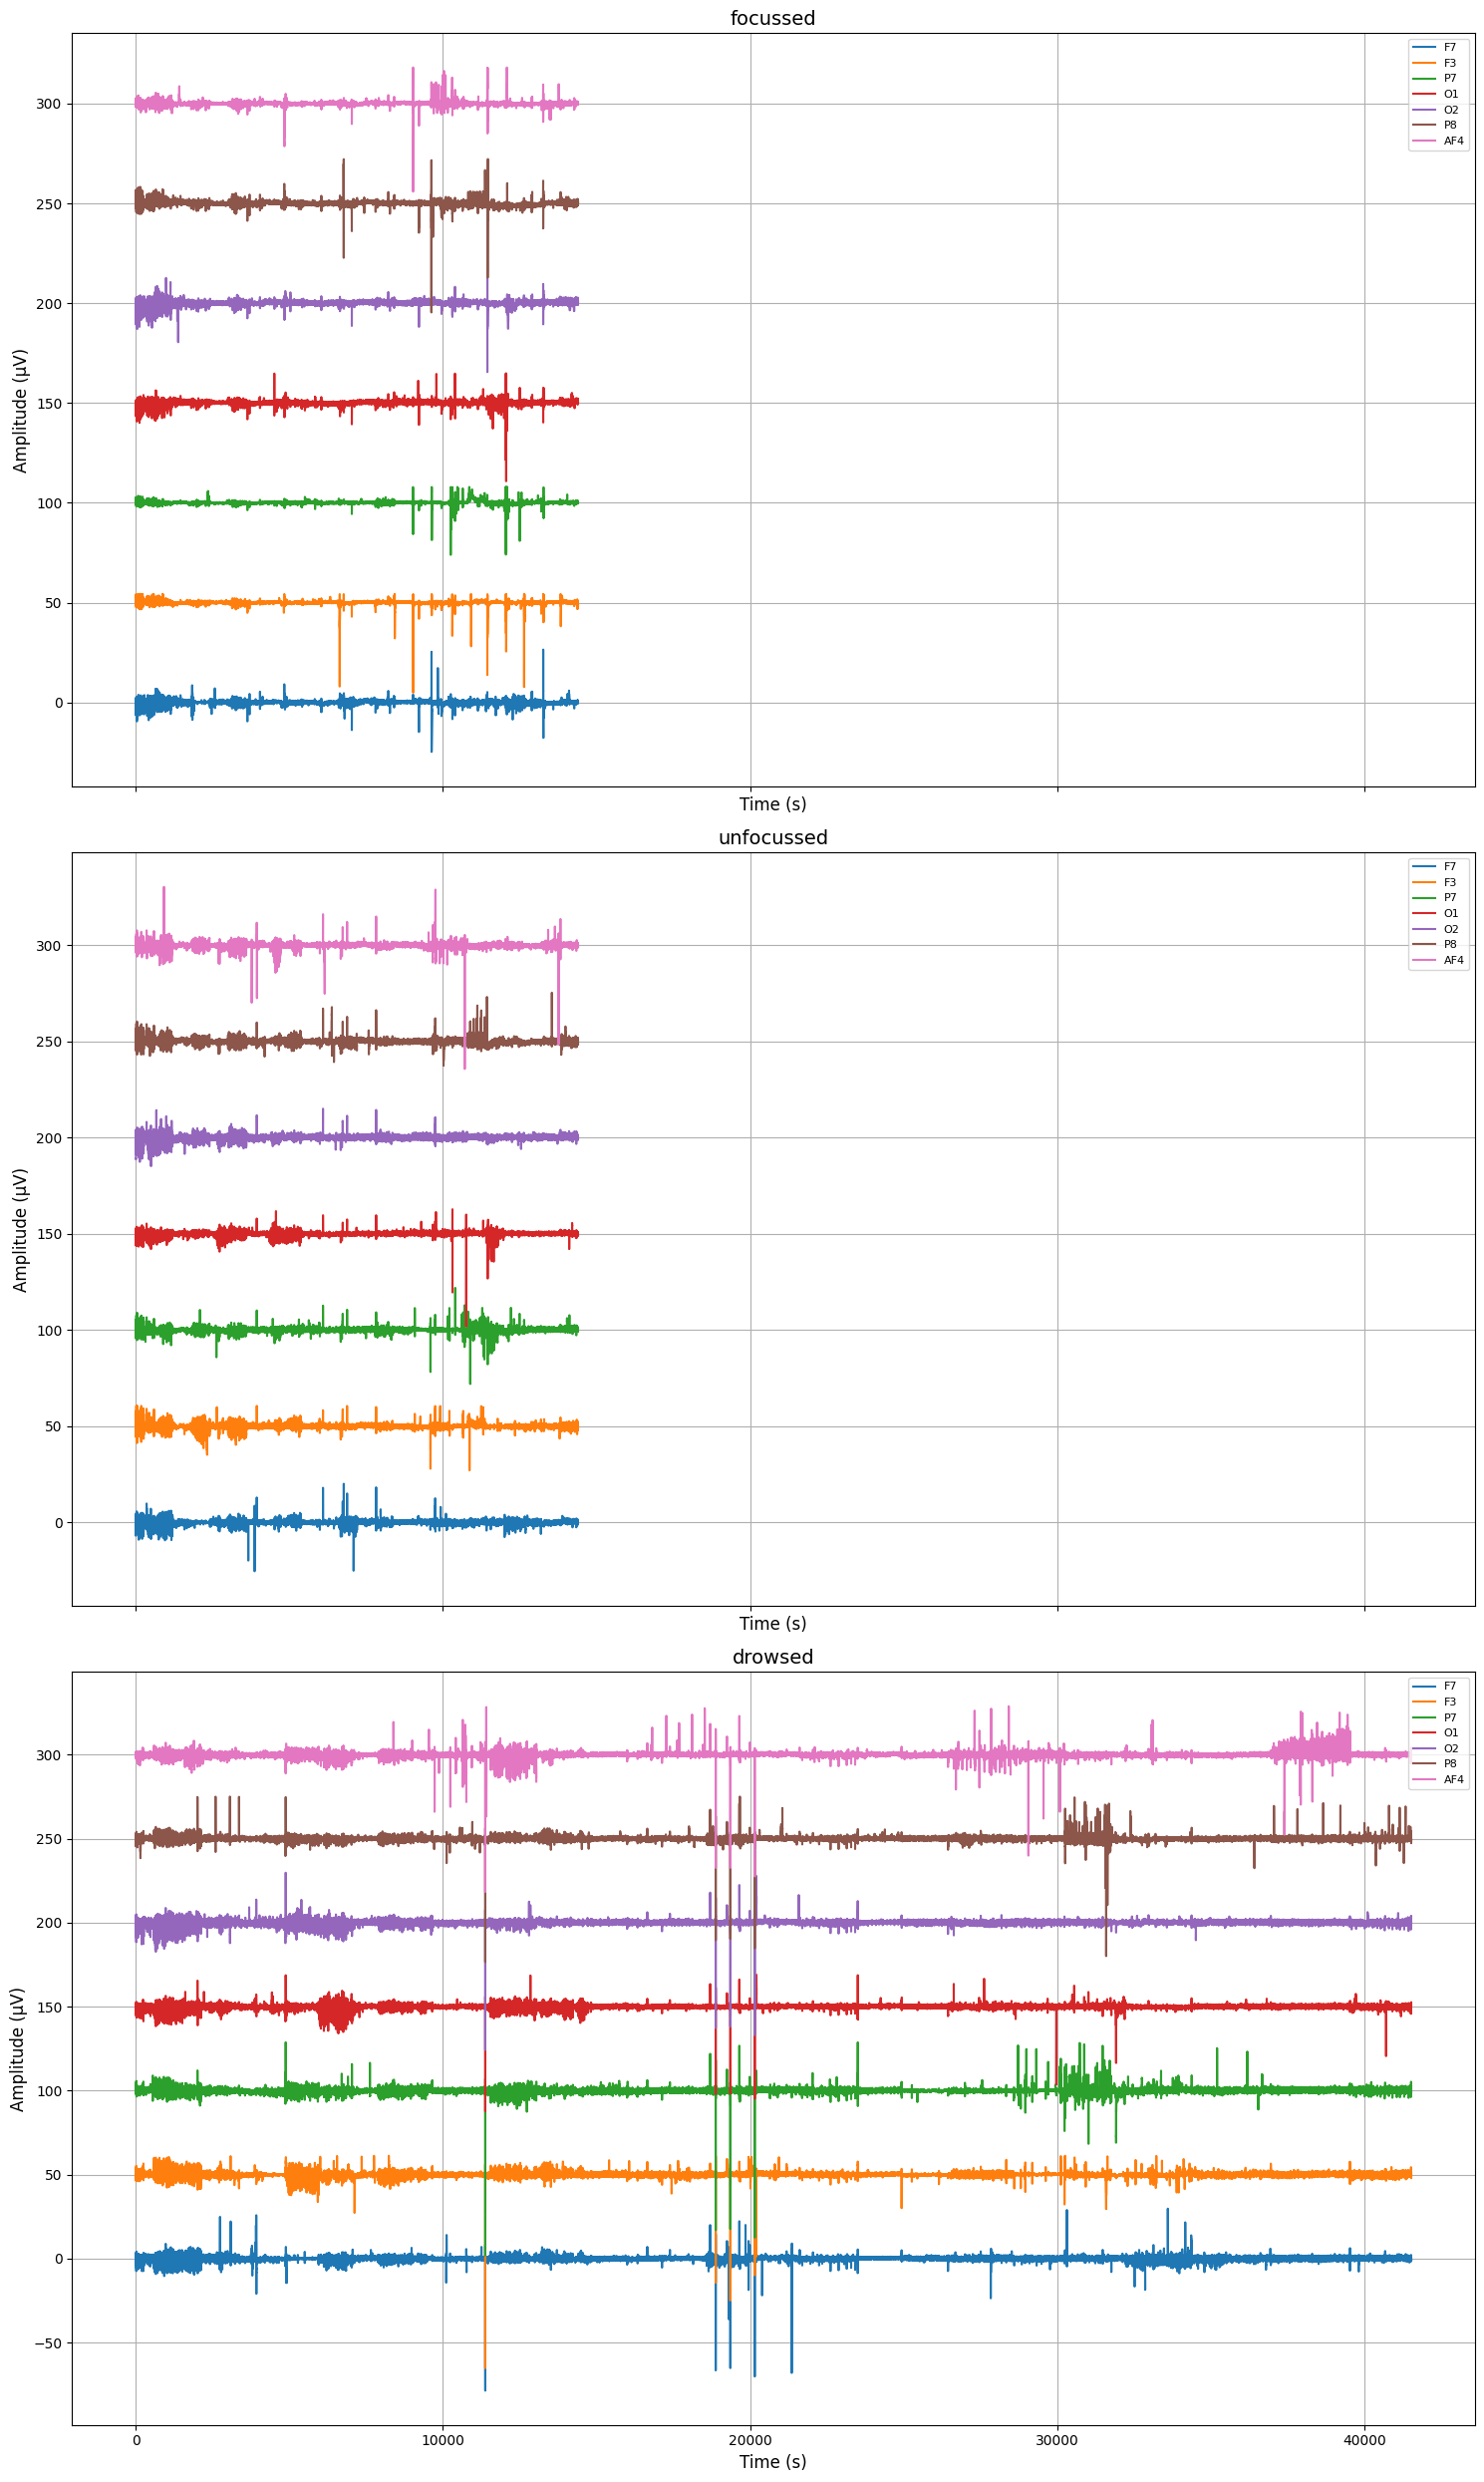

In [30]:
# Function to plot each channel by the 3 state
def plot_channel(all_data, diff = 50):
    state_labels = ['focussed', 'unfocussed', 'drowsed']
    fig, axes = plt.subplots(len(state_labels), 1, figsize=(15, 25), sharex=True)

    for j, state_label in enumerate(state_labels):
        state = all_data[state_label]
        time = np.arange(state.shape[0]) / FS
        ax = axes[j]

        for i in range(state.shape[1]):
            ax.plot(time, state[:, i] + i * diff, label=useful_channels[i])
            ax.set_title(f'{state_label}', fontsize=14)
            ax.set_xlabel('Time (s)', fontsize=12)
            ax.set_ylabel('Amplitude (μV)', fontsize=12)
            ax.legend(loc='upper right', fontsize=8)
            ax.grid(True)

    plt.tight_layout()
    plt.show()

# Plot channels
plot_channel(all_data_c)

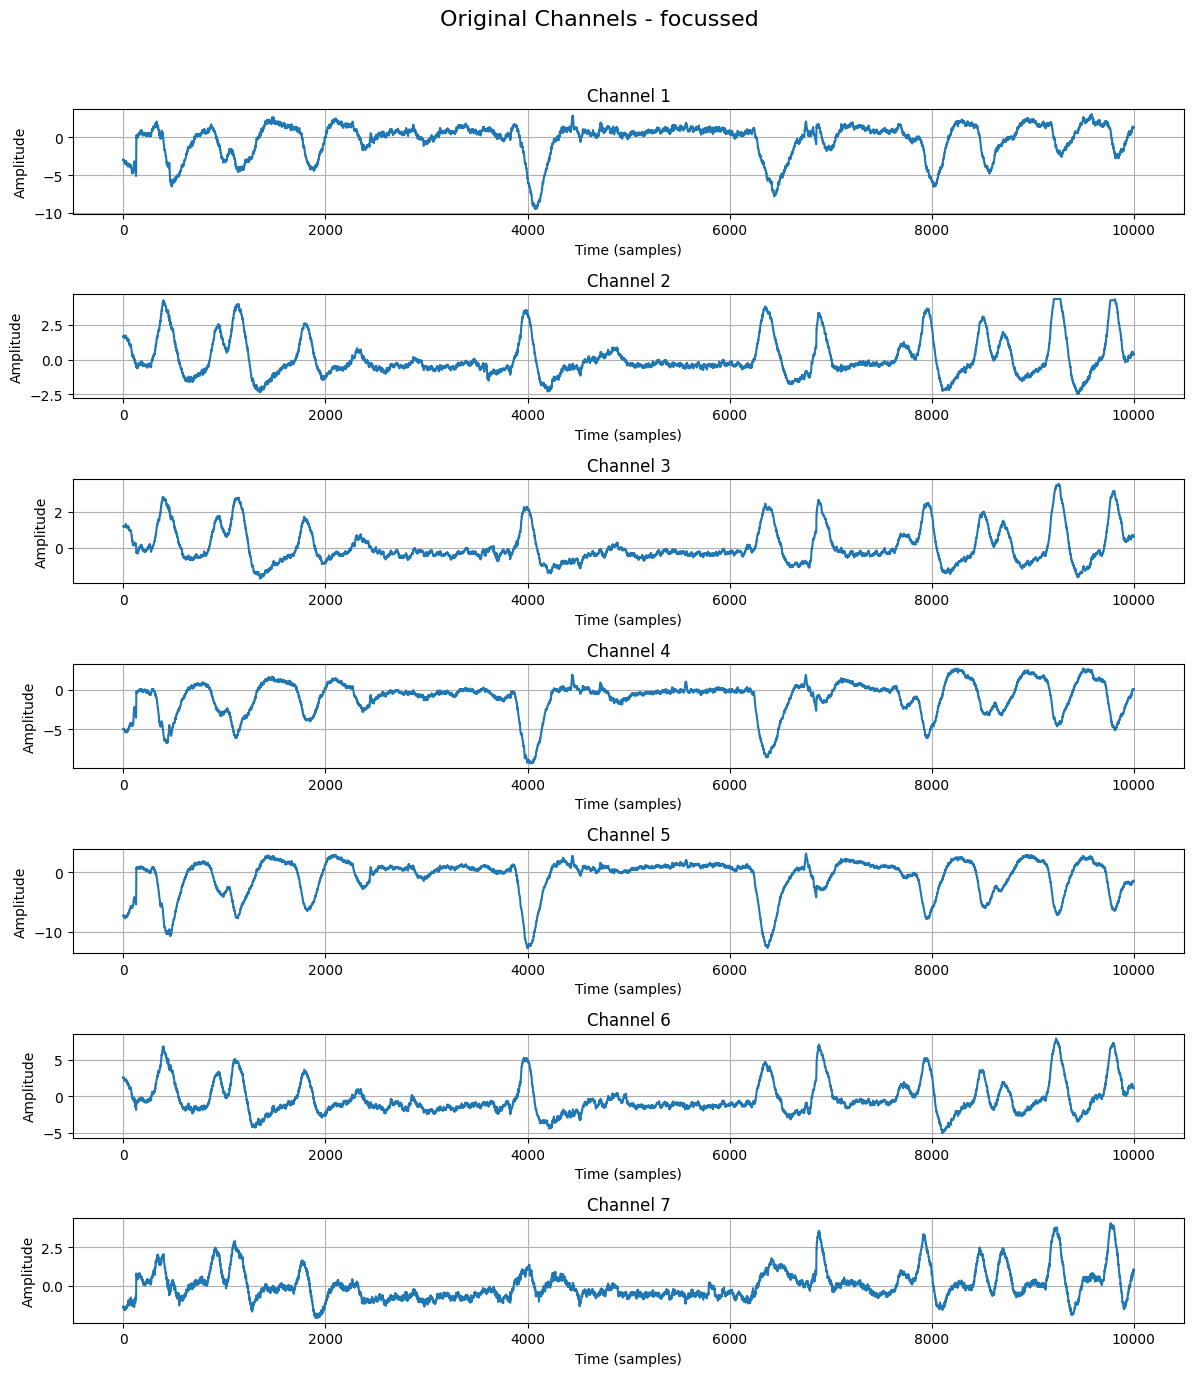

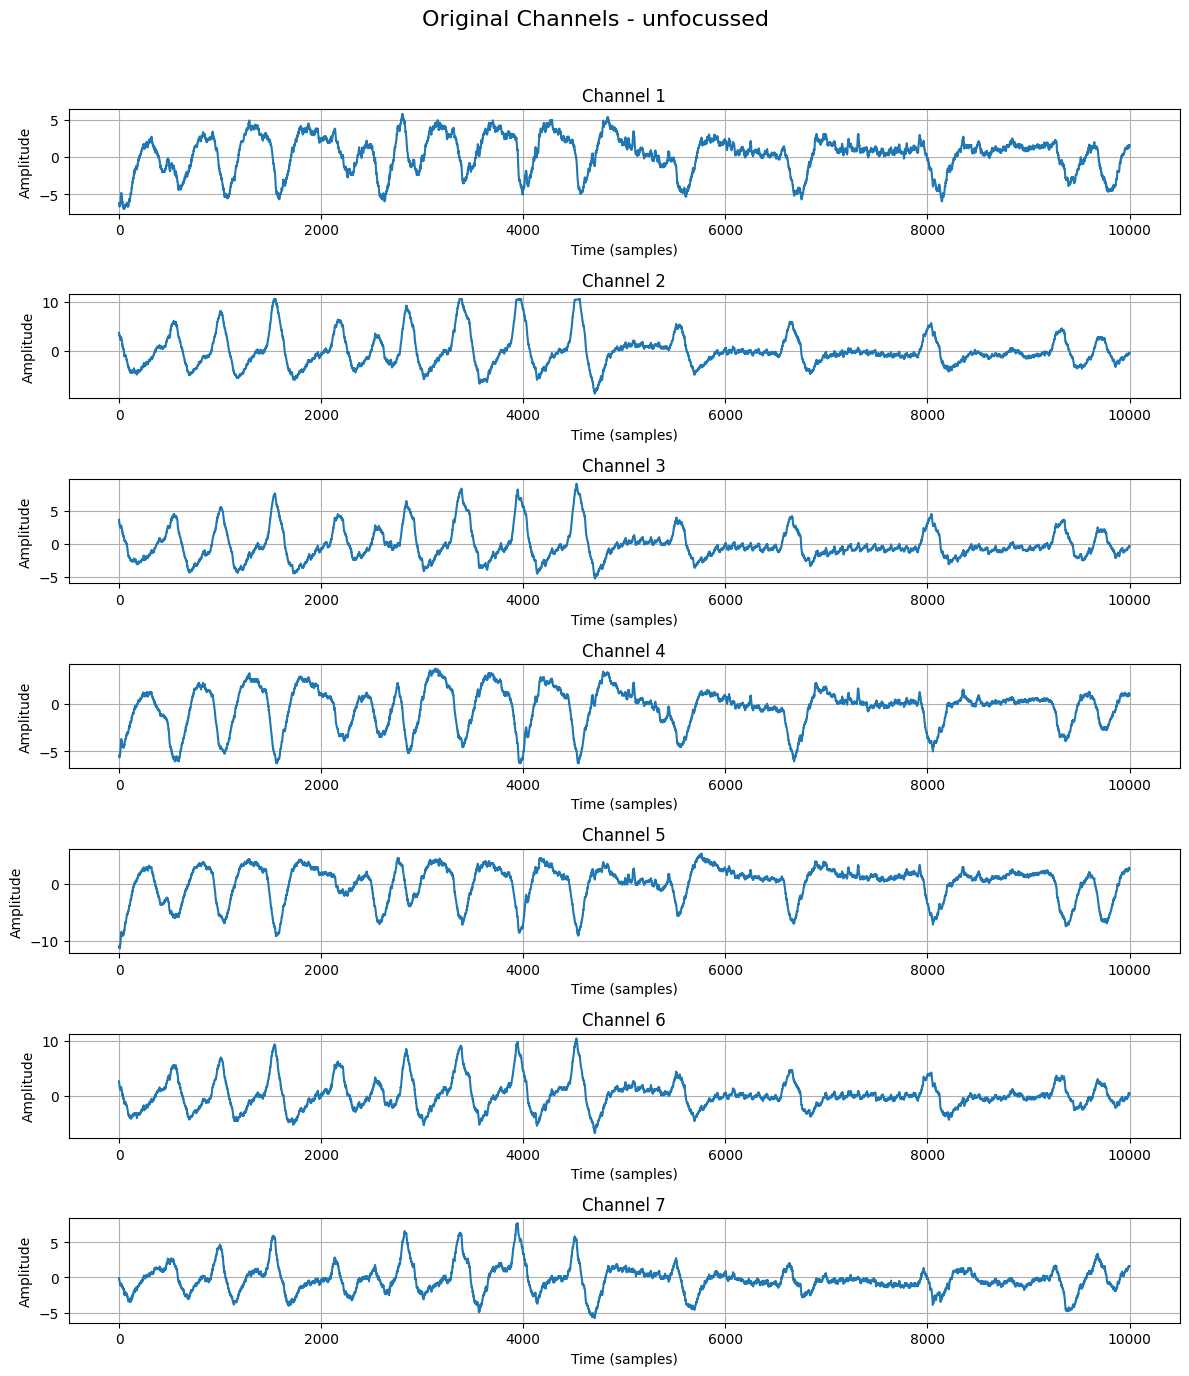

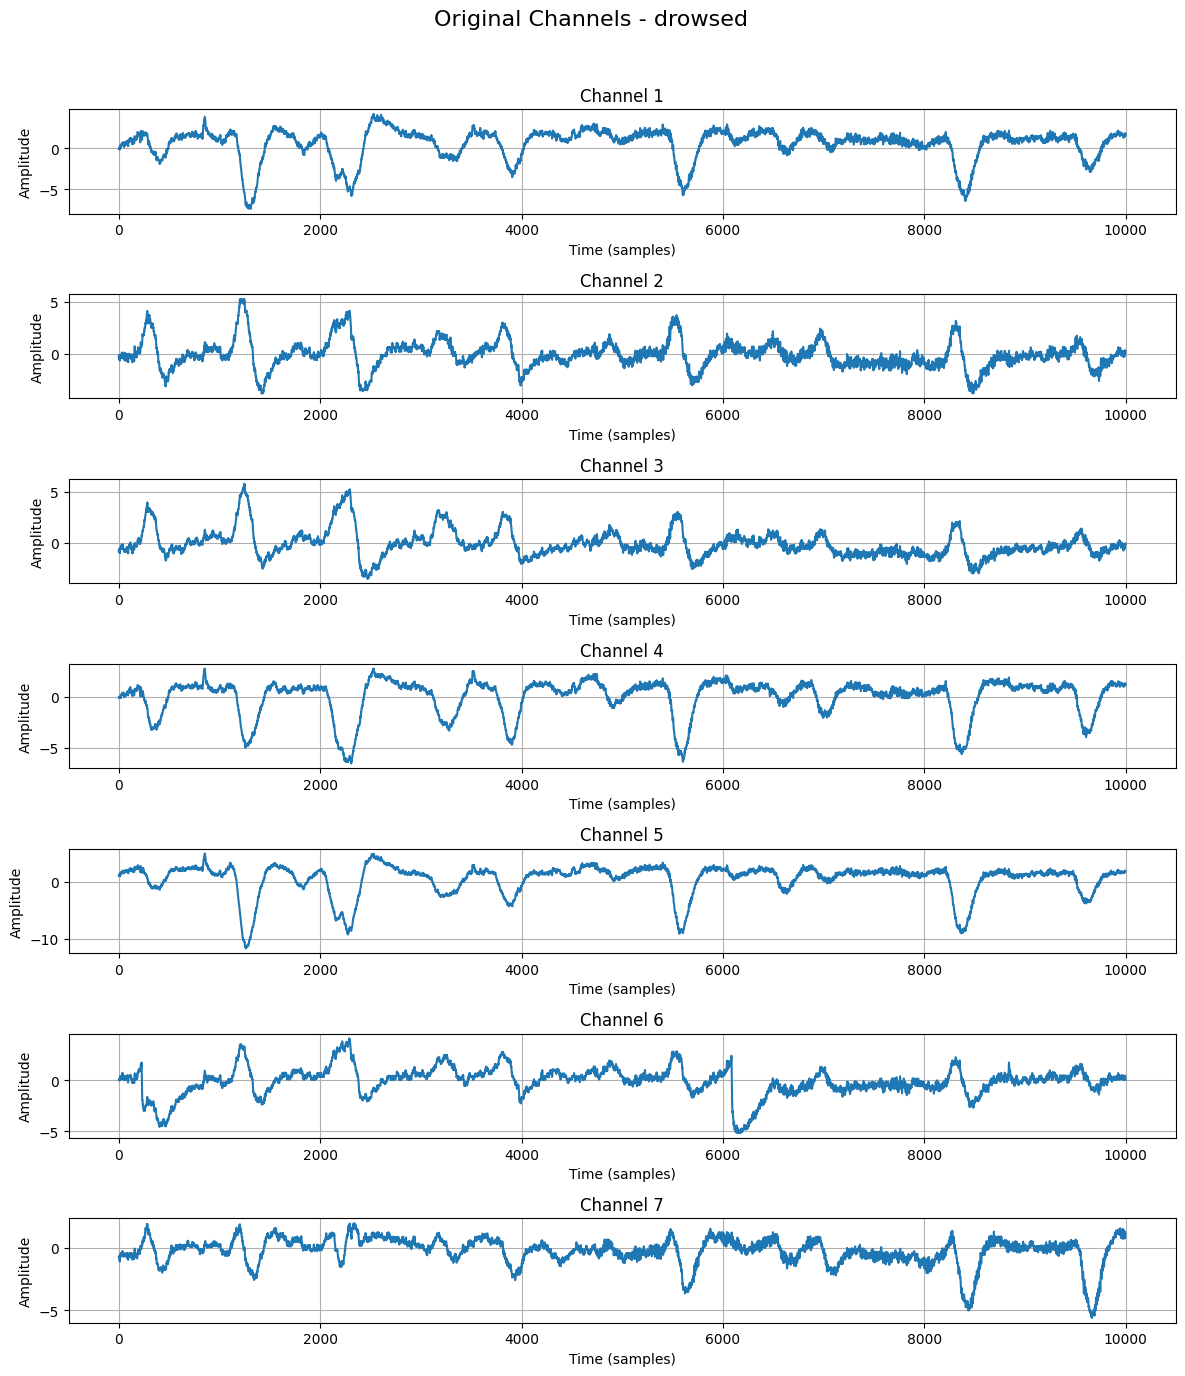

In [31]:
# Plot each channel by each state with the first 10,000 data points
state_labels = ['focussed', 'unfocussed', 'drowsed']

# Create the plots
for state_label in state_labels:
    original_data = all_data_c[state_label]  # Original data for the state
    n_channels = original_data.shape[1]  # Number of channels (columns) in the data

    fig, axes = plt.subplots(n_channels, 1, figsize=(12, 2 * n_channels))  # Create one row for each channel
    fig.suptitle(f'Original Channels - {state_label}', fontsize=16)

    for j in range(n_channels):  # Loop through each channel
        axes[j].plot(original_data[:10000, j])  # Plot the original channel (first 10,000 points)
        axes[j].set_title(f'Channel {j + 1}')
        axes[j].set_xlabel('Time (samples)')
        axes[j].set_ylabel('Amplitude')
        axes[j].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to avoid overlapping the title
    plt.show()




---



## **Feature Engineering**

In [32]:
# Convert all_data_c from dict to np
all_data_np = np.concatenate((all_data_c['focussed'], all_data_c['unfocussed'], all_data_c['drowsed']), axis=0)

In [33]:
# Constants
FS = 128  # Sampling frequency in Hz
N_CHANNELS = 7  # Number of useful channels after preprocessing
FREQ_BINS = np.arange(0.5, 18.5, 0.5)  # Target frequency bands from 0.5Hz to 18Hz
WINDOW_LENGTH = 15  # Window length for temporal smoothing in seconds# plot
WINDOW_TYPE = 'blackman'  # Blackman window for STFT
STEP_SIZE = 1  # Step size for temporal smoothing in seconds

In [34]:
# 1. STFT Calculation
def calculate_stft(data, fs, window_type, window_length_sec, step_sec):
    nperseg = window_length_sec * fs  # Number of samples in each segment
    noverlap = nperseg - (step_sec * fs)  # Overlap between segments
    window = get_window(window_type, nperseg)
    f, t, Zxx = stft(data, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap, axis=0)
    return f, t, Zxx

In [35]:
# 2. Extract Frequency Bands
def extract_frequency_bands(Zxx, f, target_bands):
    band_indices = [np.argmin(np.abs(f - freq)) for freq in target_bands]
    # Modified indexing for 2D STFT result
    selected_spectrogram = np.abs(Zxx[band_indices, :]) ** 2  # Power spectrum
    return selected_spectrogram

In [36]:
# 3. Temporal Smoothing
def temporal_smoothing(spectrogram, window_length):
    smoothed = np.apply_along_axis(
        lambda m: np.convolve(m, np.ones(window_length) / window_length, mode='same'),
        axis=-1,
        arr=spectrogram
    )
    return smoothed

In [37]:
# 4. Logarithmic Transformation (Power to Decibels)
def power_to_decibel(spectrogram):  
    return 10 * np.log10(spectrogram + 1e-8)  # Adding epsilon to avoid log(0)

In [38]:
# Process each channel separately
def process_channels(data, fs, window_type, window_length_sec, step_sec):
    all_channels_features = []

    for ch in range(N_CHANNELS):
        # Compute STFT for the current channel
        frequencies, times, stft_result = calculate_stft(
            data[:, ch], FS, WINDOW_TYPE, WINDOW_LENGTH, STEP_SIZE
        )

        # Extract features for the desired frequency bands
        spectrogram = extract_frequency_bands(stft_result, frequencies, FREQ_BINS)

        # Apply temporal smoothing
        smoothed_spectrogram = temporal_smoothing(spectrogram, window_length=WINDOW_LENGTH)

        # Convert power spectrum to decibel scale
        decibel_spectrogram = power_to_decibel(smoothed_spectrogram)

        # Append to list (preserve frequency × time for each channel)
        all_channels_features.append(decibel_spectrogram)

    # Combine all channels into one array
    all_channels_features = np.array(all_channels_features)  # Shape: (n_channels, n_freq_bins, n_time)

    # Returns reshaped array into (n_time, n_channels × n_freq_bins)
    return all_channels_features.reshape(-1, all_channels_features.shape[-1]).T

In [39]:
# Final feature matrix for creating pandas dateframe
final_feature_matrix = process_channels(all_data_np, FS, WINDOW_TYPE, WINDOW_LENGTH, STEP_SIZE)

#### Below is a flowchart to summary our feature extraction method:

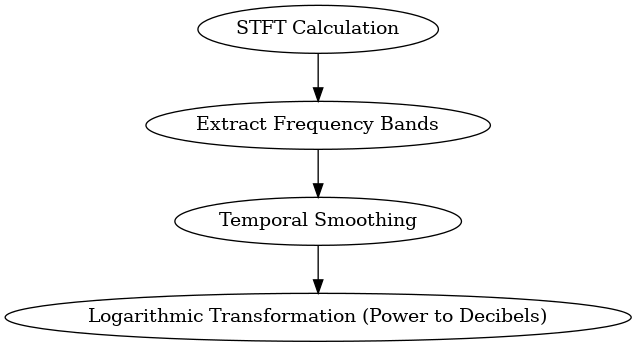

> With shape after each step is:


### **Generate and Save DataFrame of Extracted Features with Labels, Optional Heatmap Visualization**


In [40]:
# Create DataFrame
def create_dataframe(final_feature_matrix, label, fname, plot = False):
    rows = [f"Time_{i}" for i in range(final_feature_matrix.shape[0])]
    columns = [
        f"Channel_{ch}_Freq_{freq}Hz"
        for ch in range(1, N_CHANNELS + 1)
        for freq in FREQ_BINS
    ]
    dataframe = pd.DataFrame(final_feature_matrix, index=rows, columns=columns)
    dataframe['label'] = label

    # Save DataFrame to CSV
    dataframe.to_csv(fname, index=True)

    if plot:
        # Plot heatmap for visualization
        plt.figure(figsize=(12, 8))
        plt.imshow(final_feature_matrix, aspect="auto", cmap="viridis", origin="lower")
        plt.colorbar(label="Power (dB)")
        plt.title("Extracted Features as Heatmap (All Channels)")
        plt.xlabel("Frequency Bands × Channels")
        plt.ylabel("Time Frames")
        plt.show()


In [41]:
# There are total of 24 experiments
# So the label will be 24 * 10 * 60 seconds of focused state, same as unfocused state and the rest is drowsed state
n_focused = 24 * 10 * 60
n_unfocused = 24 * 10 * 60
n_drowsed = final_feature_matrix.shape[0] - n_focused - n_unfocused
label = np.array([0] * n_focused + [1] * n_unfocused + [2] * n_drowsed)

In [42]:
# Create Dataframe
create_dataframe(final_feature_matrix, label = label, fname = 'extracted_features_corrected.csv')

In [43]:
extracted_features_corrected = pd.read_csv('extracted_features_corrected.csv', index_col=0)
extracted_features_corrected

,Channel_1_Freq_0.5Hz,Channel_1_Freq_1.0Hz,Channel_1_Freq_1.5Hz,Channel_1_Freq_2.0Hz,Channel_1_Freq_2.5Hz,Channel_1_Freq_3.0Hz,Channel_1_Freq_3.5Hz,Channel_1_Freq_4.0Hz,Channel_1_Freq_4.5Hz,Channel_1_Freq_5.0Hz,...,Channel_7_Freq_14.0Hz,Channel_7_Freq_14.5Hz,Channel_7_Freq_15.0Hz,Channel_7_Freq_15.5Hz,Channel_7_Freq_16.0Hz,Channel_7_Freq_16.5Hz,Channel_7_Freq_17.0Hz,Channel_7_Freq_17.5Hz,Channel_7_Freq_18.0Hz,label
Time_0,-16.895353,-24.029650,-23.315109,-28.243945,-28.342812,-38.389900,-32.683255,-33.768898,-32.976997,-35.756465,...,-51.426768,-50.269737,-50.621549,-54.684744,-50.871673,-50.434394,-52.695067,-49.340664,-47.049563,0
Time_1,-16.484373,-23.356686,-23.227519,-28.133605,-28.280796,-38.179378,-32.641336,-33.657067,-32.931762,-35.567326,...,-50.778694,-49.903636,-49.180452,-54.193522,-49.906863,-49.862889,-52.103885,-49.283671,-47.006343,0
Time_2,-15.981965,-22.775983,-23.145439,-28.068193,-28.218130,-38.068854,-32.542803,-33.611068,-32.886805,-35.453425,...,-50.077912,-49.546538,-48.111384,-53.731807,-49.261750,-49.605303,-51.760863,-49.229863,-46.967682,0
Time_3,-15.470943,-22.363993,-23.072261,-28.028544,-28.161772,-38.014040,-32.417540,-33.592022,-32.859325,-35.386930,...,-49.576334,-49.288677,-47.331886,-53.224931,-48.803847,-49.442370,-51.590803,-49.157238,-46.860972,0
Time_4,-14.950247,-22.132663,-23.019730,-28.011904,-28.109992,-37.989977,-32.307040,-33.577807,-32.853511,-35.322698,...,-49.351406,-49.132369,-46.775436,-52.661806,-48.449084,-49.168127,-51.476527,-49.056493,-46.689697,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Time_70332,-17.964019,-24.192403,-25.140456,-28.851244,-31.798196,-42.741458,-38.306259,-34.913419,-43.453008,-35.241655,...,-40.294657,-41.645364,-47.562198,-48.070594,-43.652453,-45.271709,-44.475060,-50.376708,-48.912159,2
Time_70333,-18.390785,-24.386952,-25.396183,-29.362990,-31.803985,-43.790756,-39.175551,-35.392306,-43.672072,-35.710642,...,-40.437046,-42.182658,-47.762617,-48.370423,-43.816379,-46.016104,-44.649415,-51.036159,-49.340071,2
Time_70334,-19.041197,-24.810216,-25.806778,-30.183384,-31.831161,-44.269097,-39.854040,-36.073308,-44.247460,-36.483252,...,-40.683446,-42.726426,-47.953478,-48.424668,-44.029688,-46.879489,-44.978097,-51.645093,-49.941973,2
Time_70335,-19.974936,-25.593405,-26.471064,-31.391181,-31.930726,-44.551142,-40.269968,-36.977941,-45.321643,-37.639590,...,-41.020585,-43.332972,-48.276784,-48.485125,-44.295532,-47.738078,-45.508586,-52.029492,-50.685960,2


In [44]:
print(extracted_features_corrected.columns)

Index(['Channel_1_Freq_0.5Hz', 'Channel_1_Freq_1.0Hz', 'Channel_1_Freq_1.5Hz',
       'Channel_1_Freq_2.0Hz', 'Channel_1_Freq_2.5Hz', 'Channel_1_Freq_3.0Hz',
       'Channel_1_Freq_3.5Hz', 'Channel_1_Freq_4.0Hz', 'Channel_1_Freq_4.5Hz',
       'Channel_1_Freq_5.0Hz',
       ...
       'Channel_7_Freq_14.0Hz', 'Channel_7_Freq_14.5Hz',
       'Channel_7_Freq_15.0Hz', 'Channel_7_Freq_15.5Hz',
       'Channel_7_Freq_16.0Hz', 'Channel_7_Freq_16.5Hz',
       'Channel_7_Freq_17.0Hz', 'Channel_7_Freq_17.5Hz',
       'Channel_7_Freq_18.0Hz', 'label'],
      dtype='object', length=253)


## **Split data using 4 subjects as train and 1 subject as test**

In [45]:
# Function to divide the data into train and test data which has the subject_num as test and the other 4 is train
def divide_train_test_subject(data, subject_state_starting_index, subject_num=5):
    train_data = []
    test_data = []
    for i in range(3): # 3 states
        for j in range(N_SUBJECTS):
            if j != subject_num - 1:
                train_data.append(data[subject_state_starting_index[i * N_SUBJECTS + j]:subject_state_starting_index[i * N_SUBJECTS + j + 1],:])
            else:
                test_data.append(data[subject_state_starting_index[i * N_SUBJECTS + j]:subject_state_starting_index[i * N_SUBJECTS + j + 1],:])

    return np.concatenate(train_data), np.concatenate(test_data)

In [46]:
# Previously we have an array of data length called subject_state_len
# Now we create another array for storing first index data of each subject for each state

# The reason we create the previous array at the moment when combining all subjects into all_data dict,
# is that the drowsed data is imbalanced so it is impossible to determine the length of drowsed data of each subject after the data is combined.
subject_state_starting_index = np.concatenate(([0], subject_state_len.cumsum()))
subject_state_starting_index

array([      0,  384000,  768000, 1152000, 1536000, 1843200, 2227200,
       2611200, 2995200, 3379200, 3686400, 4694740, 5774900, 6879040,
       7812452, 9002984])

In [47]:
# Split into train and test data with subject 5 as test
train_data, test_data = divide_train_test_subject(data=all_data_np, subject_state_starting_index=subject_state_starting_index, subject_num=5)

In [48]:
# Processing channels using STFT
final_feature_matrix_train = process_channels(train_data, FS, WINDOW_TYPE, WINDOW_LENGTH, STEP_SIZE)
final_feature_matrix_test = process_channels(test_data, FS, WINDOW_TYPE, WINDOW_LENGTH, STEP_SIZE)

In [49]:
# Assigning labels for train and test set
# As subject 5 has 4 days of experiment, the train set now has total of 20 days of experimenting for 4 other subjects
n_focused_train = n_unfocused_train = 20 * 10 * 60
n_drowsed_train = final_feature_matrix_train.shape[0] - n_focused_train - n_unfocused_train
label_train = np.array([0] * n_focused_train + [1] * n_unfocused_train + [2] * n_drowsed_train)

n_focused_test = n_unfocused_test = 4 * 10 * 60
n_drowsed_test = final_feature_matrix_test.shape[0] - n_focused_test - n_unfocused_test
label_test = np.array([0] * n_focused_test + [1] * n_unfocused_test + [2] * n_drowsed_test)

In [50]:
# Create train and test dataframe
create_dataframe(final_feature_matrix_train, label = label_train, fname = 'extracted_features_train.csv')
create_dataframe(final_feature_matrix_test, label = label_test, fname = 'extracted_features_test.csv')

In [51]:
train_data = pd.read_csv('/home/huy/Desktop/Tan_Phat_DE/Pj_GK-20241206T042216Z-001/extracted_features_train.csv', index_col = 0)
test_data = pd.read_csv('/home/huy/Desktop/Tan_Phat_DE/Pj_GK-20241206T042216Z-001/extracted_features_test.csv', index_col = 0)



---



## **Model Development**

### Create NeuralNetClassifier class with fit, predict and predict_proba methods

In [52]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

class NeuralNetClassifier:
    """
    A customizable PyTorch-based implementation of a neural network classifier for tabular data.

    Features:
        - Automatically configures a feedforward neural network architecture with:
            * Two hidden layers (128 and 64 units respectively).
            * Dropout for regularization.
            * ReLU activation for non-linearity.
        - Supports weighted loss functions for handling class imbalance.
        - Manual learning rate adjustment at specified epochs.
        - Encapsulates training, prediction into reusable methods.

    Parameters:
        - input_dim (int): Number of features in the input data.
        - num_classes (int): Number of unique target classes.
        - lr (float, optional): Learning rate for the optimizer. Defaults to 0.001.
        - b_size (int, optional): Batch size for training and evaluation. Defaults to 32.
        - num_epochs (int, optional): Total number of training epochs. Defaults to 30.
        - weights (list or numpy array, optional): Class weights for handling imbalanced datasets. Defaults to None.
        - lr_adjust_epochs (list of int, optional): Epochs at which to reduce the learning rate. Defaults to None.
        - lr_factors (list of float, optional): Factors for learning rate reduction. Defaults to None.
        - device (torch.device, optional): Device to use ('cuda' or 'cpu'). Automatically detects GPU if available.
        - random_state (int, optional): Seed for random number generation to ensure reproducibility. Defaults to None.

    Methods:
        - fit(X_train, y_train): Trains the model on the given training data.
        - predict(X_test): Generates predictions for the given input data.
        - predict_proba(X_test): Generates class probabilities for the given input data.
    """

    def __init__(self, input_dim, num_classes, lr=0.001, b_size=32, num_epochs=100, weights=None, lr_adjust_epochs=None, lr_factors=None, device=None, random_state=None, module = None):
        # Define parameters
        if random_state is not None:
            self.set_random_state(random_state)

        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lr = lr
        self.b_size = b_size
        self.num_epochs = num_epochs
        self.lr_adjust_epochs = lr_adjust_epochs or []
        self.lr_factors = lr_factors or []

        # Define the model
        self.model = self.ClassificationNet(input_dim, num_classes).to(self.device)
        self.criterion = nn.CrossEntropyLoss(weight=torch.tensor(weights, dtype=torch.float32).to(self.device)) if weights else nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)

    @staticmethod
    def set_random_state(seed):
        """Set the random seed for reproducibility."""
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)
        np.random.seed(seed)
        random.seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    class ClassificationNet(nn.Module):
        def __init__(self, input_dim, num_classes):
            super().__init__()
            self.fc1 = nn.Linear(input_dim, 128)
            self.relu = nn.ReLU()
            self.dropout = nn.Dropout(0.3)
            self.fc2 = nn.Linear(128, 64)
            self.fc3 = nn.Linear(64, num_classes)

        def forward(self, x):
            x = self.fc1(x)
            x = self.relu(x)
            x = self.dropout(x)
            x = self.fc2(x)
            x = self.relu(x)
            x = self.dropout(x)
            x = self.fc3(x)
            return x

    def fit(self, X_train, y_train):
        # Prepare data
        X_train_torch = torch.tensor(X_train.to_numpy(), dtype=torch.float32).to(self.device)
        y_train_torch = torch.tensor(y_train.to_numpy(), dtype=torch.long).to(self.device)
        train_loader = DataLoader(TensorDataset(X_train_torch, y_train_torch), batch_size=self.b_size, shuffle=True)
        print(f"Learning rate at start: {self.optimizer.param_groups[0]['lr']:.5f}")

        # Training loop
        for epoch in range(self.num_epochs):
            self.model.train()
            running_loss = 0.0
            for inputs, labels in train_loader:
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()

            avg_loss = running_loss / len(train_loader)
            print(f"Epoch [{epoch+1}/{self.num_epochs}], Loss: {avg_loss:.4f}")

            # Adjust learning rate manually
            if epoch + 1 in self.lr_adjust_epochs:
                for param_group in self.optimizer.param_groups:
                    param_group['lr'] *= self.lr_factors[self.lr_adjust_epochs.index(epoch + 1)]
                print(f"Adjusted learning rate to: {self.optimizer.param_groups[0]['lr']:.5f}")

    def predict(self, X_test):
        # Prepare test data
        X_test_torch = torch.tensor(X_test.to_numpy(), dtype=torch.float32).to(self.device)
        test_loader = DataLoader(TensorDataset(X_test_torch), batch_size=self.b_size, shuffle=False)

        # Predict
        self.model.eval()
        predictions = []
        with torch.no_grad():
            for inputs in test_loader:
                outputs = self.model(inputs[0])  # Only inputs
                _, predicted = torch.max(outputs, 1)
                predictions.extend(predicted.cpu().numpy())

        return np.array(predictions)

    def predict_proba(self, X_test):
        # Prepare test data
        X_test_torch = torch.tensor(X_test.to_numpy(), dtype=torch.float32).to(self.device)
        test_loader = DataLoader(TensorDataset(X_test_torch), batch_size=self.b_size, shuffle=False)

        # Predict probabilities
        self.model.eval()
        probabilities = []
        with torch.no_grad():
            for inputs in test_loader:
                outputs = self.model(inputs[0])  # Only inputs
                probs = nn.Softmax(dim=1)(outputs)
                probabilities.extend(probs.cpu().numpy())

        return np.array(probabilities)


### **Model Trainer Class**

In [58]:
class ModelTrainer:
    """
    A class to handle model training, evaluation, and visualization for multiple machine learning models.
    """
    def __init__(self, train_data, test_data, target_column, class_names, random_state=42):
        """
        Initializes the ModelTrainer class.

        Parameters:
            - data (pd.DataFrame): Dataset containing features and target.
            - target_column (str): Name of the target column.
            - class_names (list): List of class names for evaluation and visualization.
            - test_size (float): Proportion of the dataset to include in the test split.
            - random_state (int): Seed for random operations.
        """
        self.target_column = target_column
        self.class_names = class_names
        self.random_state = random_state
        self.X_train, self.y_train = train_data.drop(columns=[target_column]), train_data[target_column]
        self.X_test, self.y_test = test_data.drop(columns=[target_column]), test_data[target_column]
        self.X_train, self.X_test = self.apply_pca(self.X_train, self.X_test)
        self.X_train, self.y_train = self.smote(self.X_train, self.y_train)

    def apply_pca(self, X_train, X_test, n_components=0.95):
        pca = PCA(n_components=n_components)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)
        print(f"Original number of features: {X_train.shape[1]}, post-PCA number of features: {X_train_pca.shape[1]}")
        return X_train, X_test
    
    def smote(self, X_train, y_train):
        sm = SMOTE(random_state=self.random_state, sampling_strategy='not majority')
        X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
        return X_train_res, y_train_res
    
    def get_models(self):
        """
        Returns a dictionary of machine learning models.
        """
        input_size = self.X_train.shape[1]  # Input size for neural networks, if needed
        models = {
            # Logistic model 
            'Logistic Regression': LogisticRegression(
                penalty='l2',
                C=0.5,
                class_weight='balanced',
                solver='saga',
                max_iter=2000,
                random_state=self.random_state
            ),
            # Random forest model
            'Random Forest': RandomForestClassifier(
                n_estimators=100,
                max_depth=10,
                min_samples_split=5,
                min_samples_leaf=4,
                random_state=self.random_state
            ),
            # Suport Vector Model
            'SVM': SVC(
                C=0.1,
                kernel='rbf',
                gamma='scale',
                probability=False,
                random_state=self.random_state
            ),
            # Neuron network 
            'Neural Network': NeuralNetClassifier(
                input_dim=input_size,
                num_classes=len(self.class_names),
                lr=1e-4,
                b_size=32,
                num_epochs=100,
                lr_adjust_epochs=[10, 20],
                lr_factors=[0.5, 0.2],
                random_state=self.random_state
            )
        }
        return models

    def evaluate_performance(self, y_test, y_pred, y_prob=None):
        """
        Evaluate and visualize the performance of a model.

        Parameters:
            - y_test: Ground truth labels.
            - y_pred: Predicted labels.
            - y_prob: Predicted probabilities (required for ROC curves).
        """
        # Calculate metrics
        acc = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        print(f"Accuracy: {acc:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=self.class_names, yticklabels=self.class_names)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
        
        print(classification_report(y_test, y_pred))

        # ROC Curve
        if y_prob is not None:
            plt.figure(figsize=(8, 6))
            if len(np.unique(y_test)) > 2:  # Multi-class case
                for i, class_name in enumerate(self.class_names):
                    fpr, tpr, _ = roc_curve(y_test == i, y_prob[:, i])
                    roc_auc = auc(fpr, tpr)
                    plt.plot(fpr, tpr, label=f"Class {class_name} (AUC = {roc_auc:.2f})")
            else:  # Binary case
                fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1])
                roc_auc = auc(fpr, tpr)
                plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")

            plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title("Receiver Operating Characteristic")
            plt.legend(loc="lower right")
            plt.show()

    def train_and_evaluate(self):
        """
        Train and evaluate all models using the training and test sets.
        """
        models = self.get_models()
        for model_name, model in models.items():
            begin = time.time()
            print(f"\nTraining and evaluating: {model_name}")
            model.fit(self.X_train, self.y_train)
            end = time.time()
            print(f"Training time: {end - begin:.2f} seconds")
            y_pred = model.predict(self.X_test)
            y_prob = model.predict_proba(self.X_test) if hasattr(model, "predict_proba") else None
            self.evaluate_performance(self.y_test, y_pred, y_prob=y_prob)

Original number of features: 252, post-PCA number of features: 120

Training and evaluating: Logistic Regression


/home/huy/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Training time: 793.04 seconds
Accuracy: 0.9150
Precision: 0.9178
Recall: 0.9150
F1 Score: 0.9159


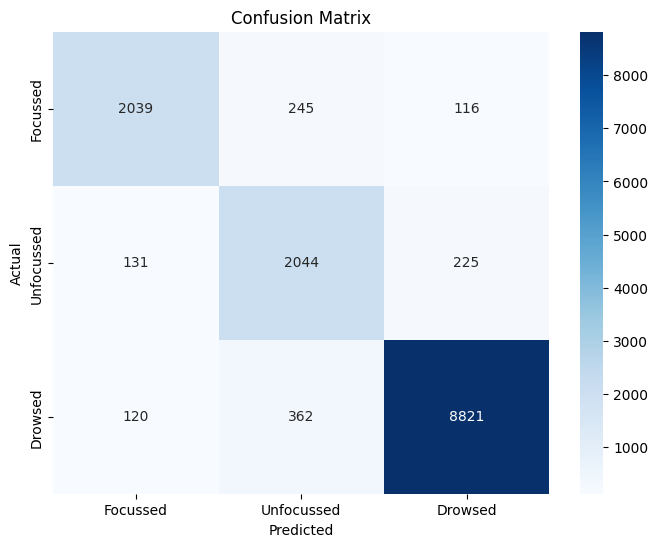

              precision    recall  f1-score   support

           0       0.89      0.85      0.87      2400
           1       0.77      0.85      0.81      2400
           2       0.96      0.95      0.96      9303

    accuracy                           0.91     14103
   macro avg       0.87      0.88      0.88     14103
weighted avg       0.92      0.91      0.92     14103



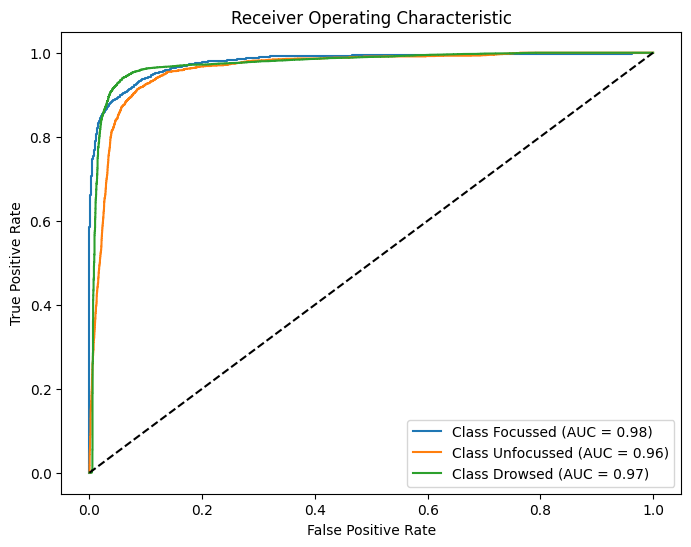


Training and evaluating: Random Forest
Training time: 123.75 seconds
Accuracy: 0.8885
Precision: 0.8928
Recall: 0.8885
F1 Score: 0.8766


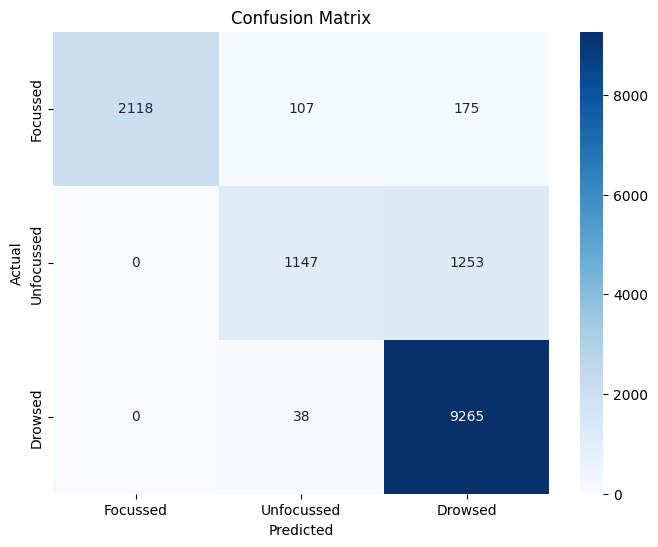

              precision    recall  f1-score   support

           0       1.00      0.88      0.94      2400
           1       0.89      0.48      0.62      2400
           2       0.87      1.00      0.93      9303

    accuracy                           0.89     14103
   macro avg       0.92      0.79      0.83     14103
weighted avg       0.89      0.89      0.88     14103



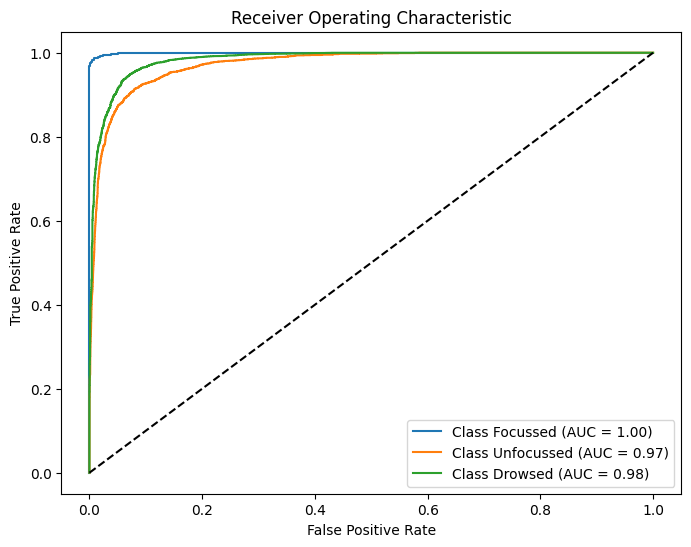


Training and evaluating: SVM
Training time: 216.67 seconds
Accuracy: 0.9755
Precision: 0.9755
Recall: 0.9755
F1 Score: 0.9752


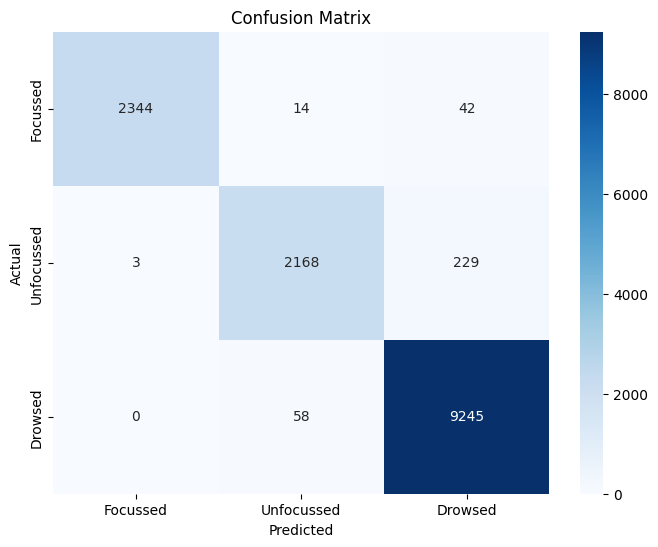

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      2400
           1       0.97      0.90      0.93      2400
           2       0.97      0.99      0.98      9303

    accuracy                           0.98     14103
   macro avg       0.98      0.96      0.97     14103
weighted avg       0.98      0.98      0.98     14103


Training and evaluating: Neural Network
Learning rate at start: 0.00010
Epoch [1/100], Loss: 0.6564
Epoch [2/100], Loss: 0.3980
Epoch [3/100], Loss: 0.3126
Epoch [4/100], Loss: 0.2723
Epoch [5/100], Loss: 0.2421
Epoch [6/100], Loss: 0.2183
Epoch [7/100], Loss: 0.2070
Epoch [8/100], Loss: 0.1926
Epoch [9/100], Loss: 0.1786
Epoch [10/100], Loss: 0.1878
Adjusted learning rate to: 0.00005
Epoch [11/100], Loss: 0.1825
Epoch [12/100], Loss: 0.1707
Epoch [13/100], Loss: 0.1657
Epoch [14/100], Loss: 0.1566
Epoch [15/100], Loss: 0.1464
Epoch [16/100], Loss: 0.1516
Epoch [17/100], Loss: 0.1422
Epoch [18/100], Loss: 0.132

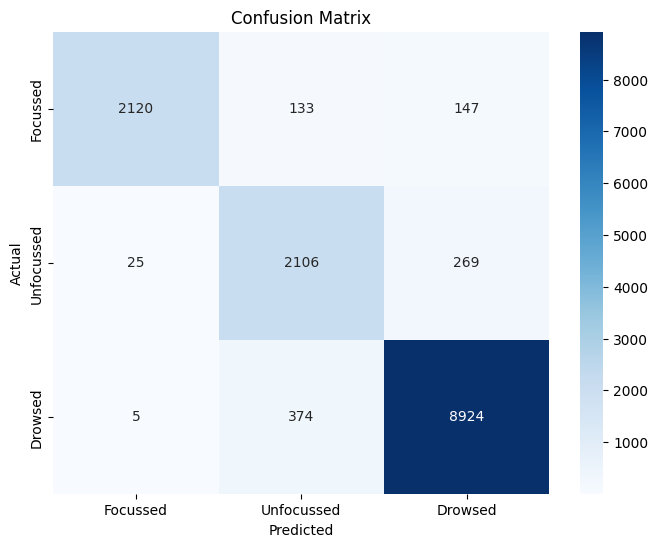

              precision    recall  f1-score   support

           0       0.99      0.88      0.93      2400
           1       0.81      0.88      0.84      2400
           2       0.96      0.96      0.96      9303

    accuracy                           0.93     14103
   macro avg       0.92      0.91      0.91     14103
weighted avg       0.94      0.93      0.93     14103



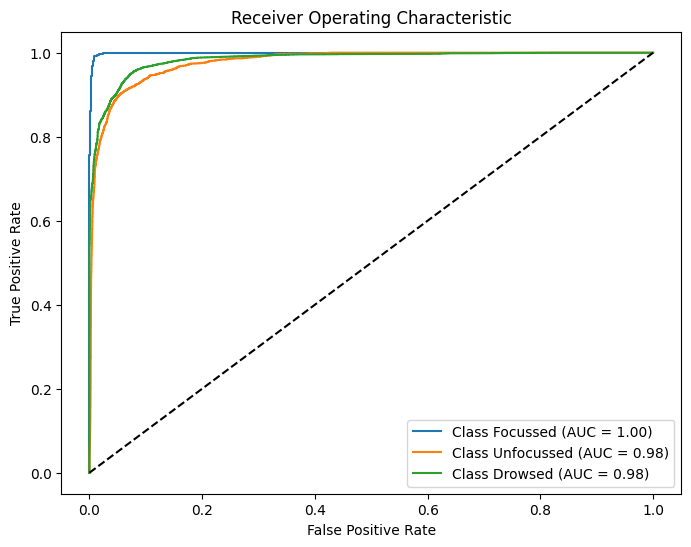

In [59]:
# Main function to execute the process
if __name__ == "__main__":

    train_data = pd.read_csv('extracted_features_train.csv', index_col=0)
    test_data = pd.read_csv('extracted_features_test.csv', index_col=0)

    target_column = 'label'
    class_names = ['Focussed', 'Unfocussed', 'Drowsed']

    trainer = ModelTrainer(train_data, test_data, target_column, class_names)
    trainer.train_and_evaluate()



---



## **Conclusion**

In this project, we compared the performance between raw EEG data and extracted feature-based data. The results clearly show that feature-extracted data significantly outperforms raw data in terms of model accuracy, training efficiency, and overall stability.

For model training, we applied various machine learning algorithms such as Logistic Regression, SVM, and Random Forest, alongside a custom deep learning model implemented using PyTorch. Preprocessing techniques like SMOTE (to address class imbalance), feature normalization (StandardScaler), and dimensionality reduction (PCA) were also integrated to improve model performance and generalization.

Throughout the process, we encountered several challenges, including class imbalance, noisy EEG signals, and inter-subject variability. These were partially mitigated through careful preprocessing and feature engineering. The best-performing models achieved accuracy as high as 96.7%, demonstrating the strong potential of machine learning for mental state classification based solely on EEG signals.

Looking ahead, further improvement could involve experimenting with more advanced feature extraction methods such as Independent Component Analysis (ICA), enhancing noise filtering techniques, or fine-tuning model hyperparameters for optimized performance.